# Data Import and Initial Exploratory Analysis

In this notebook:
- Preliminaries (importing packages, setting options)
- Read-in VOA Rating List data, build pandas dataframe and do some basic checks...currently this data is not used in the later analysis and modelling and serves only as a sense check
- Read-in VOA Summary Valuations data and conduct various preparation and cleansing tasks.  Profile key features.
- Create synthetic / aggregated features and consolidate into UARN-level modelling dataset

[This](/VOA_Data/2017CompiledListandSMVDataSpecification.pdf) technical specification document created by VOA provides a good description of the data format

## Preliminaries

In [18]:
import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm
import pickle

In [19]:
%matplotlib inline

In [20]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

## Prepare rate list data

In [21]:
ratelistfile='VOA_Data/uk-englandwales-ndr-2017-listentries-compiled-epoch-0023-baseline-csv/uk-englandwales-ndr-2017-listentries-compiled-epoch-0023-baseline-csv.csv'

In [22]:
ratelistcols=['Incrementing Entry Number', 'Billing Authority Code', 'NDR Community Code', 'BA Reference Number', 'Primary And Secondary Description Code', 
          'Primary Description Text', 'Unique Address Reference Number UARN', 'Full Property Identifier', 'Firms Name', 'Number or Name', 'Street' , 'Town', 'Postal District', 
          'County', 'Postcode', 'Effective Date', 'Composite Indicator', 'Rateable Value', 'Appeal Settlement Code', 'Assessment Reference', 'List Alteration Date', 'SCAT Code and Suffix', 
          'Sub Street level 3', 'Sub Street level 2', 'Sub Street level 1', 'Case Number', 'Current From Date', 'Current to Date']

In [23]:
# check we have 28 columns
print ('number of columns is: ' + str(len(ratelistcols))) 

number of columns is: 28


In [24]:
# import 2017 listings data
rawratelist = pd.read_csv(ratelistfile, sep='*', header=None, names=ratelistcols, index_col=False, engine='python')

In [25]:
# check a few random rows

In [26]:
rawratelist.sample(5)

,Incrementing Entry Number,Billing Authority Code,NDR Community Code,BA Reference Number,Primary And Secondary Description Code,Primary Description Text,Unique Address Reference Number UARN,Full Property Identifier,Firms Name,Number or Name,Street,Town,Postal District,County,Postcode,Effective Date,Composite Indicator,Rateable Value,Appeal Settlement Code,Assessment Reference,List Alteration Date,SCAT Code and Suffix,Sub Street level 3,Sub Street level 2,Sub Street level 1,Case Number,Current From Date,Current to Date
781129,6.0,2100,24,24122500006234,CG1,VEHICLE REPAIR WORKSHOP AND PREMISES,10561881000,"STORE AND WORKSHOP 34, ALBERT STREET, NEWPORT,...",NaN,STORE AND WORKSHOP 34,ALBERT STREET,NEWPORT,NaN,ISLE OF WIGHT,PO30 1EF,31-AUG-2017,NaN,NaN,NaN,1.988772e+10,10-JAN-2018,289G,NaN,NaN,NaN,3.000393e+10,10-JAN-2018,NaN
442258,1653.0,1250,NaN,12050010740523,CS,SHOP AND PREMISES,15635172,"1, COMMERCIAL ROAD, BOURNEMOUTH",NaN,1,COMMERCIAL ROAD,BOURNEMOUTH,NaN,NaN,BH2 5RH,NaN,NaN,101000,NaN,1.634701e+10,NaN,249G,NaN,NaN,NaN,2.071295e+10,01-APR-2017,NaN
490550,3308.0,1550,035,103500300193,CW3,STORE AND PREMISES,11943521000,"CONTAINER 44, RAWRETH BARNS, DOUBLEGATE LANE, ...",NaN,CONTAINER 44,DOUBLEGATE LANE,WICKFORD,RAWRETH,ESSEX,SS11 8UD,01-APR-2017,NaN,500,NaN,2.038261e+10,15-MAR-2019,268G,NaN,NaN,RAWRETH BARNS,3.334721e+10,15-MAR-2019,NaN
1651655,2107.0,4615,NaN,05C95900015671,IF3,WORKSHOP AND PREMISES,4324567000,"UNIT 2 R/O BM LTD, COOMBS ROAD, HALESOWEN, WES...",NaN,UNIT 2 R/O BM LTD,COOMBS ROAD,HALESOWEN,NaN,WEST MIDLANDS,B62 8AL,NaN,NaN,4400,NaN,1.618542e+10,NaN,096G,NaN,NaN,NaN,2.020560e+10,01-APR-2017,NaN
209423,36415.0,0840,NaN,24061837030023,IF3,WORKSHOP AND PREMISES,9687164000,"UNIT 23, TREGATH BUSINESS UNITS, CAMELFORD STA...",NaN,UNIT 23,CAMELFORD STATION,CAMELFORD,NaN,CORNWALL,PL32 9TZ,NaN,NaN,5600,NaN,1.830167e+10,NaN,096G,NaN,NaN,TREGATH BUSINESS UNITS,2.588811e+10,01-APR-2017,NaN


In [12]:
pickle.dump(rawratelist, open('rawratelist.p', 'wb'))

## Read and prepare summary valuations data

Its worth noting that this data contains both the current snapshot and records of historical valuations.  In addition there are seven record types in the file, each with their own structure:

1. Related list entry
2. Line items (multi line)
3. Additional items (multi line)
4. Plant and machinery
5. Car parking
6. Adjustments (multi line)
7. Adjustments totals

The unique identifier for a property is 'Unique Address Reference Number' (UARN).  The unique identifier for a valuation assessment is 'Assessment Reference'.  For this analysis, only the most recent assessment for each UARN is retained.

### Read-in data and set-up lists of columns for each record type

In [27]:
summvarfile='VOA_Data/uk-englandwales-ndr-2017-summaryvaluations-compiled-epoch-0023-baseline-csv.csv'

In [28]:
type01cols=['Record Type', 'Assessment Reference', 'Unique Address Reference Number UARN', 'Billing Authority Code', 'Firms Name', 'Number or Name', 'Sub Street level 3',
              'Sub Street level 2', 'Sub Street level 1', 'Street' , 'Town', 'Postal District', 'County', 'Postcode', 'Scheme Reference', 'Primary Description Text', 'Total Area',
              'Sub Total', 'Total Value', 'Adopted RV', 'List Year', 'BA Name', 'BA Reference Number', 'VO Ref', 'From Date', 'To Date', 'SCAT Code Only', 'Unit of Measurement', 
              'Unadjusted Price']

In [29]:
# check we have 29 columns
print ('number of columns is: ' + str(len(type01cols))) 

number of columns is: 29


In [30]:
type02cols=['Record Type', 'Line', 'Floor', 'Description', 'Area', 'Price', 'Value']

In [31]:
type03cols=['Record Type', 'Other Addition OA Description', 'OA Size', 'OA Price', 'OA Value']

In [32]:
type04cols=['Record Type', 'PM Value']

In [33]:
type05cols=['Record Type', 'CP Spaces', 'CP Spaces Value', 'CP Area', 'CP Area Value', 'CP Total']

In [34]:
type06cols=['Record Type', 'Adj Desc', 'Adj Percent']

In [35]:
type07cols=['Record Type', 'Total Before Adj', 'Total Adj']

In [36]:
infile = open(summvarfile, 'r') 
summvardata = infile.readlines()
infile.close()

In [37]:
len(summvardata)

12470214

### Build a dictionary containing a dataframe for each row type
Historical and badly-formed rows excluded during this processing

In [38]:
typedict = {
        '01':type01cols,
        '02':type02cols,        
        '03':type03cols,        
        '04':type04cols,        
        '05':type05cols,
        '06':type06cols,
        '07':type07cols        
    }

In [39]:
listdict = { type:[] for type,cols in typedict.items() }

In [40]:
badrows = []
oldrows = []

In [41]:
uarn = ''
todate = ''
assref = ''
for line in summvardata:
    try:
        recordtype = line[:2]
        data = line[:-1].split('*')
        if recordtype == '01':
            uarn = data[2]
            assref = data[1]
            todate = data[25]
        if todate == '':
            if recordtype != '01':
                data = [uarn] + [assref] + data
            listdict[recordtype].append(data)
        elif todate != '':
            oldrows.append(data)
    except:
        badrows.append(data)

In [42]:
[ print(type + ': ' + str(len(data))) for type,data in listdict.items()]

01: 2020329
02: 6913974
03: 371689
04: 59793
05: 325306
06: 128044
07: 113579


[None, None, None, None, None, None, None]

In [43]:
print('Number of rows with bad record type: ' + str(len(badrows)))

Number of rows with bad record type: 42


In [43]:
pickle.dump(listdict, open('listdict.p', 'wb'))

In [4]:
#listdict = pickle.load(open('listdict.p','rb'))

In [44]:
dfdict={}
for recordtype,cols in typedict.items():
    if recordtype == '01':
        dfdict[recordtype] = pd.DataFrame(data=listdict[recordtype],columns=cols)
    else:
        dfdict[recordtype] = pd.DataFrame(data=listdict[recordtype],columns=['UARN']+['Assessment Reference']+cols)
    print('Finished processing record type ' + recordtype)

Finished processing record type 01
Finished processing record type 02
Finished processing record type 03
Finished processing record type 04
Finished processing record type 05
Finished processing record type 06
Finished processing record type 07


### Summary stats on the seven dataframes created

In [20]:
{print(recordtype + '\n' + str(df.describe())) for recordtype,df in dfdict.items() }

01
       Record Type Assessment Reference Unique Address Reference Number UARN  \
count      2020329              2020329                              2020329   
unique           1              2020329                              1967467   
top             01          23764983000                           5421765000   
freq       2020329                    1                                   14   

       Billing Authority Code    Firms Name Number or Name Sub Street level 3  \
count                 2020329       2020329        2020329            2020329   
unique                    350         37382         917947                111   
top                      4605  The Occupier              1                      
freq                    47781       1716495          19250            2019200   

       Sub Street level 2 Sub Street level 1       Street  ... Adopted RV  \
count             2020329            2020329      2020329  ...    2020329   
unique               3173           

{None}

In [22]:
pickle.dump(dfdict, open('dfdict.p','wb'))

In [63]:
dfdict = pickle.load(open('dfdict.p','rb'))

## Further cleaning and exploratory analysis on record types: 01, 02, 03 and 05

### Focus on 01

#### Check for duplicates and also for consistency with ratings list

In [23]:
dfdict['01'][['Unique Address Reference Number UARN']].groupby('Unique Address Reference Number UARN').filter(lambda x: len(x) > 1) # Any duplicate UARNs?

,Unique Address Reference Number UARN
266,115448165
275,201364165
276,432172165
278,10327436000
280,1900303000
...,...
2020317,75850196
2020318,149850196
2020321,75809196
2020322,10000186000


In [24]:
dfdict['01'].drop_duplicates(inplace=True) # de-dup

In [25]:
dfdict['01'].columns

Index(['Record Type', 'Assessment Reference',
       'Unique Address Reference Number UARN', 'Billing Authority Code',
       'Firms Name', 'Number or Name', 'Sub Street level 3',
       'Sub Street level 2', 'Sub Street level 1', 'Street', 'Town',
       'Postal District', 'County', 'Postcode', 'Scheme Reference',
       'Primary Description Text', 'Total Area', 'Sub Total', 'Total Value',
       'Adopted RV', 'List Year', 'BA Name', 'BA Reference Number', 'VO Ref',
       'From Date', 'To Date', 'SCAT Code Only', 'Unit of Measurement',
       'Unadjusted Price'],
      dtype='object')

In [26]:
dfdict['01'] = dfdict['01'].sort_values('Assessment Reference').groupby('Unique Address Reference Number UARN').tail(1) # Keep most recent assesssment for each here

In [27]:
dfdict['01'].describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.99], include='all')

,Record Type,Assessment Reference,Unique Address Reference Number UARN,Billing Authority Code,Firms Name,Number or Name,Sub Street level 3,Sub Street level 2,Sub Street level 1,Street,...,Adopted RV,List Year,BA Name,BA Reference Number,VO Ref,From Date,To Date,SCAT Code Only,Unit of Measurement,Unadjusted Price
count,1967467,1967467,1967467,1967467,1967467,1967467,1967467,1967467,1967467,1967467,...,1967467,1967467,1967467,1967467,1967467,1967467,1967467,1967467,1967467,1967467
unique,1,1967467,1967467,350,37382,917947,111,3173,43496,102158,...,1739,1,350,1935660,1827693,1184,1,231,6,20719
top,01,23764983000,2648223000,4605,The Occupier,1,,,,HIGH STREET,...,10000,2017,Birmingham,100051961766,33528501282,01-APR-2017,,203,NIA,100.00
freq,1967467,1,1,46631,1672591,18654,1966342,1925361,1522933,68879,...,15693,1967467,46631,11,1512,1435986,1967467,452609,1110734,61425


In [45]:
rawratelist.groupby('Unique Address Reference Number UARN').filter(lambda x: len(x) > 1) # Any duplicate UARNs?

,Incrementing Entry Number,Billing Authority Code,NDR Community Code,BA Reference Number,Primary And Secondary Description Code,Primary Description Text,Unique Address Reference Number UARN,Full Property Identifier,Firms Name,Number or Name,Street,Town,Postal District,County,Postcode,Effective Date,Composite Indicator,Rateable Value,Appeal Settlement Code,Assessment Reference,List Alteration Date,SCAT Code and Suffix,Sub Street level 3,Sub Street level 2,Sub Street level 1,Case Number,Current From Date,Current to Date


In [46]:
ratelistUarns = set(rawratelist['Unique Address Reference Number UARN'].unique())

In [47]:
type01Uarns = set(dfdict['01']['Unique Address Reference Number UARN'].unique())

In [48]:
print('There are: ' + str(len(ratelistUarns)) + ' distinct UARNs  in the rate list data')
print('There are: ' + str(len(type01Uarns)) + ' distinct UARNs  in the type 1 reccords from the summary valuation data')
print('There are: ' + str(len(ratelistUarns.union(type01Uarns))) + ' distinct UARNs in total across both files')
print('There are: ' + str(len(ratelistUarns.intersection(type01Uarns))) + ' distinct UARNs in both files')
print('There are: ' + str(len(ratelistUarns.difference(type01Uarns))) + ' distinct UARNs in the rate list data which are not in the type 01 summary valuation data')
print('There are: ' + str(len(type01Uarns.difference(ratelistUarns))) + ' distinct UARNs in the type 01 summary valuation data which are not in the rate list data')

There are: 2474605 distinct UARNs  in the rate list data
There are: 1967467 distinct UARNs  in the type 1 reccords from the summary valuation data
There are: 2522050 distinct UARNs in total across both files
There are: 1920022 distinct UARNs in both files
There are: 554583 distinct UARNs in the rate list data which are not in the type 01 summary valuation data
There are: 47445 distinct UARNs in the type 01 summary valuation data which are not in the rate list data


#### Profile Adopted RV

In [ ]:
dfdict['01']['Adopted RV'] = pd.to_numeric(dfdict['01']['Adopted RV']) # convert to numeric

In [ ]:
dfdict['01']['Adopted RV'].isnull().sum() # No nans

In [ ]:
dfdict['01']['Adopted RV'].quantile([0.01,0.1,0.25,0.5,0.75,0.9,0.99])

In [ ]:
dfdict['01']['Adopted RV'][dfdict['01']['Adopted RV']<=400000].hist(bins=100) # Very skewed distribution with most properties having rateable values less than 7,000   but there being some in the milions

#### Profile SCAT Code Only

In [ ]:
dfdict['01']['SCAT Code Only'].isnull().sum() # No nans

In [ ]:
x = dfdict['01'][['Adopted RV','SCAT Code Only']].groupby('SCAT Code Only').agg({'Adopted RV':['count','mean','sum']}).sort_values(by=('Adopted RV', 'sum'), ascending=False)
x

In [ ]:
p = x[[('Adopted RV', 'sum')]].cumsum()
p.plot(title='Cumulative Adopted RV by SCAT Code')
# So first 50ish SCAT codes account for 90% of rateable value

#### Profile Unit of Measurement

In [ ]:
dfdict['01']['Unit of Measurement'].isnull().sum() # No nans

In [ ]:
dfdict['01'][['Adopted RV','Unit of Measurement']].groupby('Unit of Measurement').agg({'Adopted RV':['count','mean','sum']})

#### Now get a list of the UARN-Assessment Refs from 01 data so we can filter he other rocrd type to match 01

In [ ]:
t=list(dfdict['01'][['Unique Address Reference Number UARN','Assessment Reference']].to_records(index=False))

In [ ]:
t[:5]

### Focus on 02

In [ ]:
# Given that duplciate rows were found in 01 data, and that some 02 rows may be children of the duplicte 01 rows, lets de-dup 02 too
dfdict['02'].drop_duplicates(inplace=True)
# check length
len(dfdict['02'].index)

In [ ]:
# Make index out of UARN and assessemnt number
dfdict['02'].columns
dfdict['02'].set_index(['UARN', 'Assessment Reference'], inplace=True)
dfdict['02'].columns
dfdict['02'].index

In [ ]:
dfdict['02'] = dfdict['02'][dfdict['02'].index.isin(t)]
len(dfdict['02'].index) # Check length - should be reduced

In [ ]:
# Convert to numeric
dfdict['02'][['Area', 'Price','Value']] = dfdict['02'][['Area', 'Price','Value']].apply(pd.to_numeric,errors='coerce')
dfdict['02'][cols].isna().sum()
# No nulls for price and value, but 400000 missing areas

### Profile Description

In [118]:
# Look at description
x=dfdict['02'].reset_index().groupby('Description').agg({'UARN':'nunique', 'Area': ['mean','sum'], 'Price':['mean','sum'], 'Value':['mean','sum']}).sort_values(by=('Value','sum'),ascending=False)
x

UARN         Area  \
                                            nunique         mean   
Description                                                        
Office                                       820793    87.500494   
Retail Zone A                                478065    32.272790   
Warehouse                                    147317   696.510155   
All Main Areas                                 9862  2072.655219   
Ground Floor Sales                            57318   269.739293   
...                                             ...          ...   
Crown Double Advertising Display                 45     3.100000   
Double Demy Advertising Display                   7     4.285714   
Quad Demy Advertising Display                     4     3.666667   
Tack Room                                         4    10.556000   
Notional Living Accommodation (Valued At 0)       1          NaN   

                                                                Price  \
                                                      sum        mean   
Description                                                             
Office                                       1.341229e+08  105.194373   
Retail Zone A                                1.633968e+07  322.152324   
Warehouse                                    1.363467e+08   44.983452   
All Main Areas                               3.077064e+07  177.740848   
Ground Floor Sales                           1.812324e+07  568.300387   
...                                                   ...         ...   
Crown Double Advertising Display             1.395000e+02   56.088889   
Double Demy Advertising Display              3.000000e+01   51.428571   
Quad Demy Advertising Display                1.100000e+01  141.250000   
Tack Room                                    5.278000e+01   20.168000   
Notional Living Accommodation (Valued At 0)  0.000000e+00    0.000000   

                                                                   Value  \
                                                      sum           mean   
Description                                                                
Office                                       1.614496e+08   12472.504453   
Retail Zone A                                1.631289e+08   11224.482920   
Warehouse                                    8.820265e+06   27044.875544   
All Main Areas                               2.650116e+06  347332.982830   
Ground Floor Sales                           3.821195e+07   43529.443626   
...                                                   ...            ...   
Crown Double Advertising Display             2.524000e+03     160.177778   
Double Demy Advertising Display              3.600000e+02     260.000000   
Quad Demy Advertising Display                5.650000e+02     405.000000   
Tack Room                                    1.008400e+02     196.200000   
Notional Living Accommodation (Valued At 0)  0.000000e+00       0.000000   

                                                          
                                                     sum  
Description                                               
Office                                       19142475549  
Retail Zone A                                 5683763865  
Warehouse                                     5302905107  
All Main Areas                                5178734774  
Ground Floor Sales                            2926876260  
...                                                  ...  
Crown Double Advertising Display                    7208  
Double Demy Advertising Display                     1820  
Quad Demy Advertising Display                       1620  
Tack Room                                            981  
Notional Living Accommodation (Valued At 0)            0  

[149 rows x 7 columns]

<AxesSubplot:title={'center':'Cumulative Value by Description'}, xlabel='Description'>

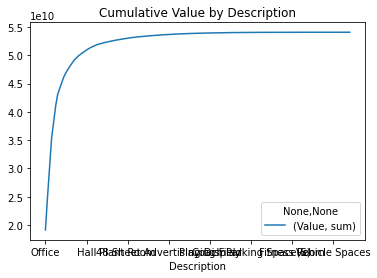

In [119]:
p = x[[('Value', 'sum')]].cumsum()
p.plot(title='Cumulative Value by Description')
# So first 40ish descriptions account for 90% of rateable value

#### Profile Floor

In [ ]:
x = dfdict['02'].reset_index().groupby('Floor').agg({'UARN':'nunique', 'Area': ['mean','sum'], 'Price':['mean','sum'], 'Value':['mean','sum']}).sort_values(by=('Value','sum'),ascending=False)
x[:20]

<AxesSubplot:xlabel='Floor'>

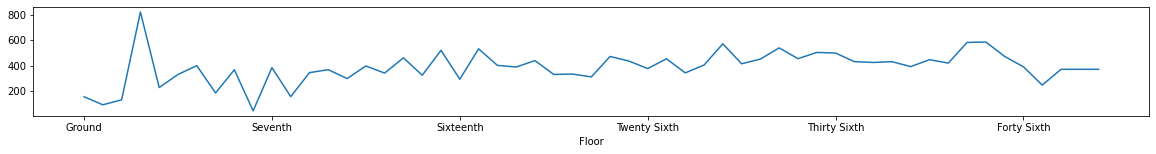

In [117]:
x[('Price','mean')].plot(figsize=(20,2))

So mostly there is only ground floor...but higher floors have higher prices

#### Profile Line

In [114]:
# Look at line
dfdict['02'].reset_index().groupby('Line').agg({'UARN':'nunique', 'Area': ['mean','sum'], 'Price':['mean','sum'], 'Value':['mean','sum']}).sort_values(by=('Value','sum'),ascending=False)

UARN        Area                     Price                \
      nunique        mean           sum        mean           sum   
Line                                                                
1     1967466  174.275319  3.406150e+08  314.719648  6.192002e+08   
2     1128268   74.576309  8.019616e+07  119.921309  1.353034e+08   
3      872140   65.088685  5.238956e+07   81.168811  7.079057e+07   
4      646945   68.419694  3.969786e+07   68.788034  4.450207e+07   
5      464963   72.462457  3.006141e+07   64.831874  3.014442e+07   
...       ...         ...           ...         ...           ...   
444         1   11.800000  1.180000e+01   27.590000  2.759000e+01   
395         2    6.655000  1.331000e+01   70.295000  1.405900e+02   
431         1    2.800000  2.800000e+00   45.980000  4.598000e+01   
442         1    6.500000  6.500000e+00   19.310000  1.931000e+01   
410         2    0.840000  8.400000e-01   59.140000  1.182800e+02   

             Value               
              mean          sum  
Line                             
1     15786.259050  31058927948  
2      5785.965729   6528119981  
3      4278.755934   3731674200  
4      3964.521001   2564827039  
5      4036.365223   1876760483  
...            ...          ...  
444     326.000000          326  
395     156.500000          313  
431     129.000000          129  
442     126.000000          126  
410      49.500000           99  

[445 rows x 7 columns]

Not particularly exciting

### Create UARN-level features for analysis and modelling

In [125]:
dfdict['02']['02FloorCat'] = np.where(dfdict['02']['Floor'].isin(['Ground','First','Second']),'GroundFirstOrSecond','OtherFloor')

In [126]:
dfdict['02']['02DescCat'] = np.where(dfdict['02']['Description'].isin(x.head(40).index.to_list()),dfdict['02']['Description'],'OtherDescription')

In [155]:
z = dfdict['02'].reset_index().groupby(['UARN','Assessment Reference','02FloorCat']).agg({'Area':'sum'}).reset_index().pivot(index=['UARN','Assessment Reference'],columns='02FloorCat',values='Area').fillna(0)

In [156]:
zz=dfdict['02'].reset_index().groupby(['UARN','Assessment Reference','02DescCat']).agg({'Area':'sum'}).reset_index().pivot(index=['UARN','Assessment Reference'],columns='02DescCat',values='Area').fillna(0)

### Begin to build modelling dataset
Using features from record types 01 and 02 for now

In [144]:
dfdict['01'].rename(columns={'Unique Address Reference Number UARN': 'UARN'},inplace=True)
dfdict['01'].set_index(['UARN', 'Assessment Reference'], inplace=True)
dfdict['01'].columns

Index(['Record Type', 'Billing Authority Code', 'Firms Name', 'Number or Name',
       'Sub Street level 3', 'Sub Street level 2', 'Sub Street level 1',
       'Street', 'Town', 'Postal District', 'County', 'Postcode',
       'Scheme Reference', 'Primary Description Text', 'Total Area',
       'Sub Total', 'Total Value', 'Adopted RV', 'List Year', 'BA Name',
       'BA Reference Number', 'VO Ref', 'From Date', 'To Date',
       'SCAT Code Only', 'Unit of Measurement', 'Unadjusted Price'],
      dtype='object')

In [157]:
mod = dfdict['01'][['Billing Authority Code', 'Firms Name', 'Town', 'Postal District', 'County', 'Postcode',
       'Scheme Reference', 'Primary Description Text', 'Total Area',
       'Sub Total', 'Total Value', 'Adopted RV',
       'SCAT Code Only', 'Unit of Measurement', 'Unadjusted Price']]

In [158]:
mod.head(5)

,,Billing Authority Code,Firms Name,Town,Postal District,County,Postcode,Scheme Reference,Primary Description Text,Total Area,Sub Total,Total Value,Adopted RV,SCAT Code Only,Unit of Measurement,Unadjusted Price
UARN,Assessment Reference,,,,,,,,,,,,,,,
8153752000,15615563000,4230,The Occupier,,SALFORD,,M5 3NN,283505,Car Parking Spaces And Premises,3.00,1500,1500,1500,043,NIA,500.00
8467837000,15615566000,4230,The Occupier,,SALFORD,,M5 3NN,283505,Car Parking Spaces,56.00,28000,28000,28000,043,NIA,500.00
8467842000,15615567000,4230,The Occupier,,SALFORD,,M5 3NN,283505,Car Parking Spaces,49.00,24500,24500,24500,043,NIA,500.00
6278241000,15615595000,4215,The Occupier,,MANCHESTER,,M22 5WB,283486,Car Parking Space And Premises,1.00,400,400,400,043,OTH,400.00
6278243000,15615596000,4215,The Occupier,,MANCHESTER,,M22 5WB,283486,Car Parking Space And Premises,1.00,400,400,400,043,OTH,400.00


In [159]:
mod = mod.join(z)

In [160]:
mod = mod.join(zz)

In [161]:
mod.head(5)

,,Billing Authority Code,Firms Name,Town,Postal District,County,Postcode,Scheme Reference,Primary Description Text,Total Area,Sub Total,...,"Rough Surfaced, Fenced Land",Showroom,Single Bed Space,Store,Surgery,Total Floor Area - Dry (Leisure Clubs),"Unsurfaced, Fenced Land",Warehouse,Works Office,Workshop
UARN,Assessment Reference,,,,,,,,,,,,,,,,,,,,,
8153752000,15615563000,4230,The Occupier,,SALFORD,,M5 3NN,283505,Car Parking Spaces And Premises,3.00,1500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8467837000,15615566000,4230,The Occupier,,SALFORD,,M5 3NN,283505,Car Parking Spaces,56.00,28000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8467842000,15615567000,4230,The Occupier,,SALFORD,,M5 3NN,283505,Car Parking Spaces,49.00,24500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6278241000,15615595000,4215,The Occupier,,MANCHESTER,,M22 5WB,283486,Car Parking Space And Premises,1.00,400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6278243000,15615596000,4215,The Occupier,,MANCHESTER,,M22 5WB,283486,Car Parking Space And Premises,1.00,400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Focus on 03

#### Cleaning

In [162]:
# Given that duplciate rows were found in 01 data, and that some 03 rows may be children of the duplicte 01 rows, lets de-dup 03 too
dfdict['03'].drop_duplicates(inplace=True)
# check length
len(dfdict['03'].index)

363720

In [163]:
dfdict['03'].set_index(['UARN', 'Assessment Reference'], inplace=True)

In [164]:
# Filter for most recent assessment
dfdict['03'] = dfdict['03'][dfdict['03'].index.isin(t)]

In [167]:
# Convert to numeric
dfdict['03'][['OA Size', 'OA Price','OA Value']] = dfdict['03'][['OA Size', 'OA Price','OA Value']].apply(pd.to_numeric,errors='coerce')
dfdict['03'][['OA Size', 'OA Price','OA Value']].isna().sum()

OA Size     2126
OA Price    2129
OA Value       3
dtype: int64

#### Profile Other Addition OA Description

In [171]:
x=dfdict['03'].reset_index().groupby('Other Addition OA Description').agg({'UARN':'nunique', 'OA Size': 'mean', 'OA Price':'mean', 'OA Value':['mean','sum']}).sort_values(by=('OA Value','sum'),ascending=False)
x

UARN      OA Size     OA Price  \
                                         nunique         mean         mean   
Other Addition OA Description                                                
Hard Surfaced, Fenced Land                 39371  1057.336909     7.835713   
Petrol Forecourt and Shop                   2126          NaN          NaN   
Air Conditioning System                    88380   219.064804     6.721081   
Vehicle Display Spaces                      4969    31.253756   274.037295   
Mezzanine Floor                             2614   566.789899    30.420523   
...                                          ...          ...          ...   
Lower Ground Floor Sales                      10   162.040000    35.850000   
Car Wash (Class A-)                            9     1.000000  4000.000000   
Surfaced Airstrip                              9   244.622222  2611.555556   
Upper Floor Sales (Ie Above First Floor)       7   115.237500   264.250000   
Basement Stores In A Retail Unit               5    57.020000     6.100000   

                                              OA Value               
                                                  mean          sum  
Other Addition OA Description                                        
Hard Surfaced, Fenced Land                 4858.518064  210869401.0  
Petrol Forecourt and Shop                 56043.289276  119148033.0  
Air Conditioning System                    1310.860012  118727213.0  
Vehicle Display Spaces                     6977.276956   58043967.0  
Mezzanine Floor                           17941.690095   54883630.0  
...                                                ...          ...  
Lower Ground Floor Sales                   4077.900000      40779.0  
Car Wash (Class A-)                        4000.000000      36000.0  
Surfaced Airstrip                          3936.111111      35425.0  
Upper Floor Sales (Ie Above First Floor)   2496.625000      19973.0  
Basement Stores In A Retail Unit            242.200000       1211.0  

[95 rows x 5 columns]

<AxesSubplot:title={'center':'Cumulative OA Value by OA Description'}, xlabel='Other Addition OA Description'>

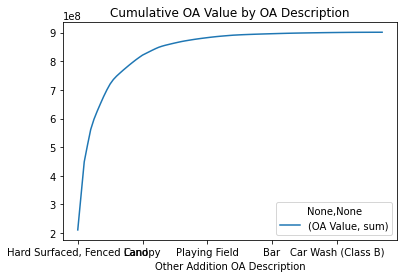

In [172]:
p = x[[('OA Value', 'sum')]].cumsum()
p.plot(title='Cumulative OA Value by OA Description')

#### Create 03 OA descrition category feature at UARN level and append to modelling dataset

In [174]:
dfdict['03']['03OADescCat'] = np.where(dfdict['03']['Other Addition OA Description'].isin(x.head(20).index.to_list()),dfdict['03']['Other Addition OA Description'],'OtherOADescription')

In [176]:
zzz=dfdict['03'].reset_index().groupby(['UARN','Assessment Reference','03OADescCat']).agg({'OA Size':'sum'}).reset_index().pivot(index=['UARN','Assessment Reference'],columns='03OADescCat',values='OA Size').fillna(0)

In [181]:
mod = mod.join(zzz, lsuffix='_02', rsuffix='_03')
mod.sample(20).transpose()

KeyboardInterrupt: 

In [182]:
mod.sample(20).transpose()

UARN,10464635000,118284147,12413174000,11551033000,6153940000,1903847000,408133195,3726070000,480436042,11015937000,11135399000,186317084,35386155,3444195000,6743297000,1255817000,144972182,5464315000,8634514000,121042253
Assessment Reference,18645188000,16406539000,21416399000,20265974000,16978488000,18029585000,16593632000,17485561000,16777718000,20326087000,19768609000,18086987000,16004140000,17795104000,16463854000,17882540000,18067240000,15983154000,17652304000,18039969000
Billing Authority Code,4405,2230,4205,3010,6810,4605,6854,6930,1025,2735,2935,5960,3810,4215,1210,5390,1110,2805,2730,2003
Firms Name,The Occupier,,The Occupier,The Occupier,The Occupier,The Occupier,The Occupier,The Occupier,The Occupier,The Occupier,The Occupier,The Occupier,The Occupier,The Occupier,The Occupier,The Occupier,The Occupier,The Occupier,The Occupier,
Town,WILTHORPE,,LOSTOCK,MORTON,NANT GWYNANT,,YSTRADGYNLAIS,,DRAYCOTT,,,,,,HURN,,,,,
Postal District,BARNSLEY,GRAVESEND,BOLTON,RETFORD,CAERNARFON,BIRMINGHAM,SWANSEA,PORT TALBOT,DERBY,SELBY,STOCKSFIELD,LONDON,BOGNOR REGIS,MANCHESTER,CHRISTCHURCH,LONDON,EXETER,CORBY,SCARBOROUGH,SCUNTHORPE
County,SOUTH YORKSHIRE,KENT,,NOTTS,,,,,,NORTH YORKSHIRE,NORTHD,,WEST SUSSEX,,DORSET,,,NORTHANTS,NORTH YORKSHIRE,LINCS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Unsurfaced, Fenced Land_03",NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Unsurfaced, Unfenced Land",NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle Display Spaces,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Focus on 05

#### Cleaning

In [183]:
# Given that duplicate rows were found in 01 data, and that some 05 rows may be children of the duplicte 01 rows, lets de-dup 05 too
dfdict['05'].drop_duplicates(inplace=True)
# check length
len(dfdict['05'].index)

325306

In [184]:
dfdict['05'].set_index(['UARN', 'Assessment Reference'], inplace=True)

In [185]:
# Filter for most recent assessment
dfdict['05'] = dfdict['05'][dfdict['05'].index.isin(t)]

In [186]:
# Convert to numeric
dfdict['05'][['CP Spaces', 'CP Spaces Value', 'CP Area', 'CP Area Value', 'CP Total']] = dfdict['05'][['CP Spaces', 'CP Spaces Value', 'CP Area', 'CP Area Value', 'CP Total']].apply(pd.to_numeric,errors='coerce')
dfdict['05'][['CP Spaces', 'CP Spaces Value', 'CP Area', 'CP Area Value', 'CP Total']].isna().sum()

CP Spaces            9193
CP Spaces Value         0
CP Area            303458
CP Area Value           0
CP Total                0
dtype: int64

#### Profile car parking spaces

In [189]:
# Look at CP Spaces
x=dfdict['05'].reset_index().groupby('CP Spaces').agg({'UARN':'nunique', 'CP Spaces Value': 'mean', 'CP Area':'mean', 'CP Area Value':'mean', 'CP Total':['mean','sum']}).sort_values(by=('CP Total','sum'),ascending=False)
x

UARN CP Spaces Value     CP Area CP Area Value    CP Total  \
          nunique            mean        mean          mean        mean   
CP Spaces                                                                 
2.0         50966      323.308362  102.012346      0.387101  323.695464   
4.0         28141      518.245229  325.030000      1.995238  520.240468   
6.0         18752      699.150917  392.936364      2.432381  701.583298   
3.0         30259      433.235930  154.887500      0.815889  434.051819   
10.0        12565      915.041862  541.655556      1.708237  916.750099   
...           ...             ...         ...           ...         ...   
540.0           3        0.000000         NaN      0.000000    0.000000   
539.0           1        0.000000         NaN      0.000000    0.000000   
536.0           2        0.000000         NaN      0.000000    0.000000   
533.0           1        0.000000         NaN      0.000000    0.000000   
10840.0         1        0.000000         NaN      0.000000    0.000000   

                     
                sum  
CP Spaces            
2.0        16497463  
4.0        14640087  
6.0        13156090  
3.0        13133974  
10.0       11518965  
...             ...  
540.0             0  
539.0             0  
536.0             0  
533.0             0  
10840.0           0  

[809 rows x 6 columns]

#### Create UARN-level number of car parking spaces feature and append to modelling dataset

In [190]:
zzzz=dfdict['05'].reset_index().groupby(['UARN','Assessment Reference']).agg({'CP Spaces':'sum'}).fillna(0)

In [192]:
mod = mod.join(zzzz)

## Complete modelling dataset and pickle for use later

In [218]:
mod.describe(include='all', percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.99]).transpose()

,count,unique,top,freq,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
Billing Authority Code,1967467,350,4605,46631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Firms Name,1967467,37382,The Occupier,1672591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Town,1967467,17329,,1425359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Postal District,1967467,1280,LONDON,227470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
County,1967467,47,,957619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Postcode,1967467,381012,S74 9SB,1846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Scheme Reference,1967467,61223,362167,6247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Primary Description Text,1967467,20989,Shop And Premises,433972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total Area,1.96747e+06,NaN,NaN,NaN,353.412,2133.13,0,1,5,27.77,79.2,208.2,562.8,4923.15,428000
Sub Total,1.96747e+06,NaN,NaN,NaN,27479.2,162403,0,227,1280,3060,6825,16017,43745.4,359264,3.24019e+07


In [196]:
# Add postal areas
exp='[A-Z][A-Z]{0,1}'

In [203]:
x = mod['Postcode'].str.findall(exp)

In [204]:
y = [ item[1][0] for item in x.items() ]
mod['Postal Area'] = y

In [213]:
colstonumeric=['Total Area','Sub Total','Total Value','Unadjusted Price']
mod[colstonumeric] = mod[colstonumeric].apply(pd.to_numeric,errors='coerce')

In [217]:
numeric_cols = mod.select_dtypes(include=np.number).columns.tolist()
mod[numeric_cols] = mod[numeric_cols].fillna(value=0)

In [219]:
pickle.dump(mod, open('mod.p', 'wb'))